In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import callbacks

import os

In [20]:
# Yahoo tools for downloading Yahoo market data
import yfinance as yf
from yahoofinancials import YahooFinancials


def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

stock_df.shape:  (2517, 7)


,Date,Open,High,Low,Close,Volume
0,2012-09-04,1406.540039,1409.310059,1396.560059,1404.939941,3200310000
1,2012-09-05,1404.939941,1408.810059,1401.250000,1403.439941,3389110000
2,2012-09-06,1403.739990,1432.119995,1403.739990,1432.119995,3952870000
3,2012-09-07,1432.119995,1437.920044,1431.449951,1437.920044,3717620000
4,2012-09-10,1437.920044,1438.739990,1428.979980,1429.079956,3223670000
...,...,...,...,...,...,...
2512,2022-08-29,4034.580078,4062.989990,4017.419922,4030.610107,2963020000
2513,2022-08-30,4041.250000,4044.979980,3965.209961,3986.159912,3190580000
2514,2022-08-31,4000.669922,4015.370117,3954.530029,3955.000000,3797860000
2515,2022-09-01,3936.729980,3970.229980,3903.649902,3966.850098,3754570000


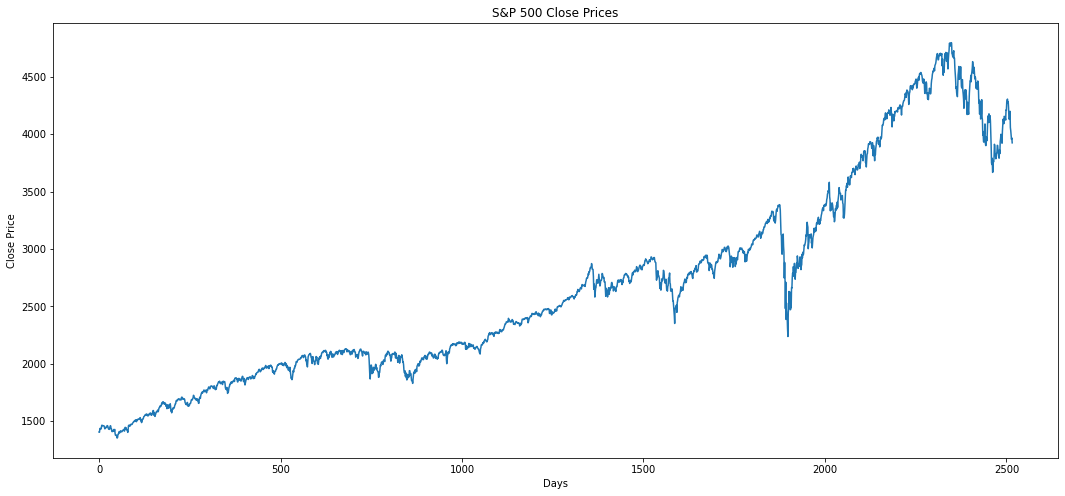

In [21]:
stock_names = ["^GSPC"]
all_train_data =[]
all_validation_data =[]

gspc = yf.Ticker(stock_names[0])
stock_df = gspc.history(period="10y")
stock_df.index.name = "Date"
stock_df = stock_df.sort_values('Date')
#stock_df['Close'] = stock_df['Close'].apply(lambda x: float(x.replace(',', '')))
#stock_df['Volume'] = stock_df['Volume'].apply(lambda x: float(x.replace(',', '')))

print("stock_df.shape: ", stock_df.shape)

data = stock_df
#print(data)
df = pd.DataFrame(data, columns = ['Open','High','Low','Close','Volume'])
df = df.reset_index(level=0)
display(df)
data = df

plt.figure(figsize=(18, 8))
plt.plot(range(df.shape[0]), df['Close'], )
plt.title("S&P 500 Close Prices")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.show()

In [22]:
length_data = len(data)     # rows that data has
split_ratio = 0.8           # %80 train + %20 validation + test
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 2517
Train data length : 2014
Validation data lenth : 503


In [23]:
train_data = data[:length_train].iloc[:,[0, 4]] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Close
0,2012-09-04,1404.939941
1,2012-09-05,1403.439941
2,2012-09-06,1432.119995
3,2012-09-07,1437.920044
4,2012-09-10,1429.079956
...,...,...
2009,2020-08-28,3508.010010
2010,2020-08-31,3500.310059
2011,2020-09-01,3526.649902
2012,2020-09-02,3580.840088


In [24]:
validation_data = data[length_train:].iloc[:,[0, 4]]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
print(validation_data.shape)
validation_data

(503, 2)


,Date,Close
2014,2020-09-04,3426.959961
2015,2020-09-08,3331.840088
2016,2020-09-09,3398.959961
2017,2020-09-10,3339.189941
2018,2020-09-11,3340.969971
...,...,...
2512,2022-08-29,4030.610107
2513,2022-08-30,3986.159912
2514,2022-08-31,3955.000000
2515,2022-09-01,3966.850098


In [25]:
dataset_train = train_data.Close.values
dataset_train.shape

(2014,)

In [26]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(2014, 1)

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(2014, 1)

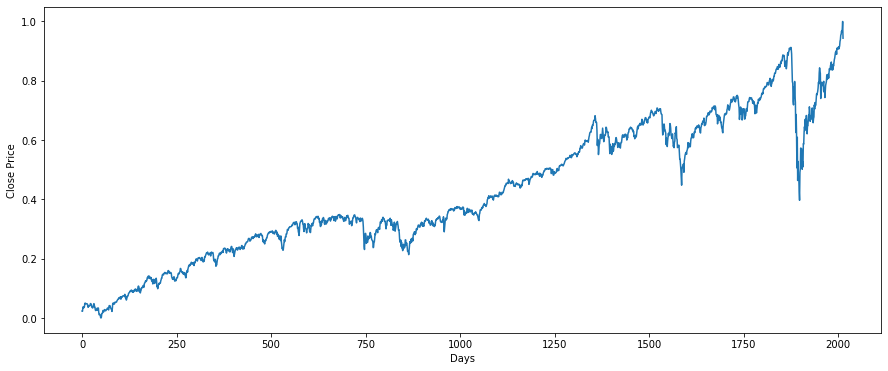

In [28]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.show()

In [29]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1964, 50)
Shape of y_train before reshape : (1964,)


In [30]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :", X_train.shape)
print("Shape of y_train after reshape :", y_train.shape)

Shape of X_train after reshape : (1964, 50, 1)
Shape of y_train after reshape : (1964, 1)


In [31]:
from keras import callbacks

lstm2_medium = Sequential()

#Input layer
lstm2_medium.add(
    LSTM(256,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm2_medium.add(Dropout(rate=0.2))

#First hidden layer
lstm2_medium.add(
    LSTM(256,return_sequences=True)) #64 lstm neuron block
lstm2_medium.add(Dropout(rate=0.2))

#Output layer
lstm2_medium.add(
    LSTM(256, return_sequences= False))

lstm2_medium.add(Dense(32))
lstm2_medium.add(Dense(1))

initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

callback = callbacks.LearningRateScheduler(lr_time_based_decay)
lstm2_medium.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory2_medium = lstm2_medium.fit(X_train, y_train, validation_split=0.1, epochs = 200, batch_size = 32, callbacks=[callback])

Epoch 1/200
56/56 [==============================] - 18s 270ms/step - loss: 0.0216 - accuracy: 5.6593e-04 - val_loss: 0.0053 - val_accuracy: 0.0051 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - 15s 261ms/step - loss: 5.2043e-04 - accuracy: 5.6593e-04 - val_loss: 0.0054 - val_accuracy: 0.0051 - lr: 9.9990e-04
Epoch 3/200
56/56 [==============================] - 14s 257ms/step - loss: 4.7218e-04 - accuracy: 5.6593e-04 - val_loss: 0.0049 - val_accuracy: 0.0051 - lr: 9.9970e-04
Epoch 4/200
56/56 [==============================] - 15s 262ms/step - loss: 4.9279e-04 - accuracy: 5.6593e-04 - val_loss: 0.0046 - val_accuracy: 0.0051 - lr: 9.9940e-04
Epoch 5/200
56/56 [==============================] - 15s 265ms/step - loss: 4.9306e-04 - accuracy: 5.6593e-04 - val_loss: 0.0043 - val_accuracy: 0.0051 - lr: 9.9900e-04
Epoch 6/200
56/56 [==============================] - 15s 267ms/step - loss: 4.8446e-04 - accuracy: 5.6593e-04 - val_loss: 0.0041 - val_accuracy: 0.0051 - lr: 9.985

In [32]:
from keras import callbacks

lstm2_large = Sequential()

#Input layer
lstm2_large.add(
    LSTM(512,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm2_large.add(Dropout(rate=0.2))

#First hidden layer
lstm2_large.add(
    LSTM(512,return_sequences=True)) #64 lstm neuron block
lstm2_large.add(Dropout(rate=0.2))

#Output layer
lstm2_large.add(
    LSTM(512, return_sequences= False))

lstm2_large.add(Dense(32))
lstm2_large.add(Dense(1))

initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

callback = callbacks.LearningRateScheduler(lr_time_based_decay)
lstm2_large.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory2_large = lstm2_large.fit(X_train, y_train, validation_split=0.1, epochs = 200, batch_size = 32, callbacks=[callback])

Epoch 1/200
56/56 [==============================] - 53s 885ms/step - loss: 0.0215 - accuracy: 5.6593e-04 - val_loss: 0.0036 - val_accuracy: 0.0051 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - 48s 854ms/step - loss: 5.4736e-04 - accuracy: 5.6593e-04 - val_loss: 0.0036 - val_accuracy: 0.0051 - lr: 9.9990e-04
Epoch 3/200
56/56 [==============================] - 47s 840ms/step - loss: 3.5195e-04 - accuracy: 5.6593e-04 - val_loss: 0.0032 - val_accuracy: 0.0051 - lr: 9.9970e-04
Epoch 4/200
56/56 [==============================] - 46s 823ms/step - loss: 5.1659e-04 - accuracy: 5.6593e-04 - val_loss: 0.0042 - val_accuracy: 0.0051 - lr: 9.9940e-04
Epoch 5/200
56/56 [==============================] - 47s 849ms/step - loss: 3.7652e-04 - accuracy: 5.6593e-04 - val_loss: 0.0033 - val_accuracy: 0.0051 - lr: 9.9900e-04
Epoch 6/200
56/56 [==============================] - 48s 849ms/step - loss: 3.5157e-04 - accuracy: 5.6593e-04 - val_loss: 0.0028 - val_accuracy: 0.0051 - lr: 9.985

In [33]:
from keras import callbacks

lstm1_large = Sequential()

#Input layer
lstm1_large.add(
    LSTM(512,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm2_large.add(Dropout(rate=0.2))

#Output layer
lstm1_large.add(
    LSTM(512, return_sequences= False))

lstm1_large.add(Dense(32))
lstm1_large.add(Dense(1))

initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

callback = callbacks.LearningRateScheduler(lr_time_based_decay)
lstm1_large.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory1_large = lstm1_large.fit(X_train, y_train, validation_split=0.1, epochs = 200, batch_size = 32, callbacks=[callback])

Epoch 1/200
56/56 [==============================] - 29s 492ms/step - loss: 0.0064 - accuracy: 5.6593e-04 - val_loss: 0.0022 - val_accuracy: 0.0051 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - 26s 473ms/step - loss: 2.2613e-04 - accuracy: 5.6593e-04 - val_loss: 0.0019 - val_accuracy: 0.0051 - lr: 9.9990e-04
Epoch 3/200
56/56 [==============================] - 27s 475ms/step - loss: 1.8955e-04 - accuracy: 5.6593e-04 - val_loss: 0.0019 - val_accuracy: 0.0051 - lr: 9.9970e-04
Epoch 4/200
56/56 [==============================] - 27s 487ms/step - loss: 2.5559e-04 - accuracy: 5.6593e-04 - val_loss: 0.0016 - val_accuracy: 0.0051 - lr: 9.9940e-04
Epoch 5/200
56/56 [==============================] - 27s 478ms/step - loss: 1.9433e-04 - accuracy: 5.6593e-04 - val_loss: 0.0016 - val_accuracy: 0.0051 - lr: 9.9900e-04
Epoch 6/200
56/56 [==============================] - 27s 484ms/step - loss: 1.9084e-04 - accuracy: 5.6593e-04 - val_loss: 0.0016 - val_accuracy: 0.0051 - lr: 9.985

In [36]:
from keras import callbacks

lstm2_medium_final = Sequential()

#Input layer
lstm2_medium_final.add(
    LSTM(256,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm2_medium_final.add(Dropout(rate=0.2))

#First hidden layer
lstm2_medium_final.add(
    LSTM(256,return_sequences=True)) #64 lstm neuron block
lstm2_medium_final.add(Dropout(rate=0.2))

#Output layer
lstm2_medium_final.add(
    LSTM(256, return_sequences= False))

lstm2_medium_final.add(Dense(32))
lstm2_medium_final.add(Dense(1))

initial_learning_rate = 0.01
epochs = 200
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

callback = callbacks.LearningRateScheduler(lr_time_based_decay)
lstm2_medium_final.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory2_medium_final = lstm2_medium_final.fit(X_train, y_train, validation_split=0.1, epochs = 200, batch_size = 32, callbacks=[callback])

Epoch 1/200
56/56 [==============================] - 18s 268ms/step - loss: 0.0281 - accuracy: 5.6593e-04 - val_loss: 0.0056 - val_accuracy: 0.0051 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - 16s 284ms/step - loss: 6.2605e-04 - accuracy: 5.6593e-04 - val_loss: 0.0082 - val_accuracy: 0.0051 - lr: 9.9995e-04
Epoch 3/200
56/56 [==============================] - 16s 285ms/step - loss: 5.2733e-04 - accuracy: 5.6593e-04 - val_loss: 0.0051 - val_accuracy: 0.0051 - lr: 9.9985e-04
Epoch 4/200
56/56 [==============================] - 16s 290ms/step - loss: 5.4726e-04 - accuracy: 5.6593e-04 - val_loss: 0.0056 - val_accuracy: 0.0051 - lr: 9.9970e-04
Epoch 5/200
56/56 [==============================] - 16s 284ms/step - loss: 5.3528e-04 - accuracy: 5.6593e-04 - val_loss: 0.0048 - val_accuracy: 0.0051 - lr: 9.9950e-04
Epoch 6/200
56/56 [==============================] - 16s 286ms/step - loss: 5.1330e-04 - accuracy: 5.6593e-04 - val_loss: 0.0051 - val_accuracy: 0.0051 - lr: 9.992

(1964, 1)


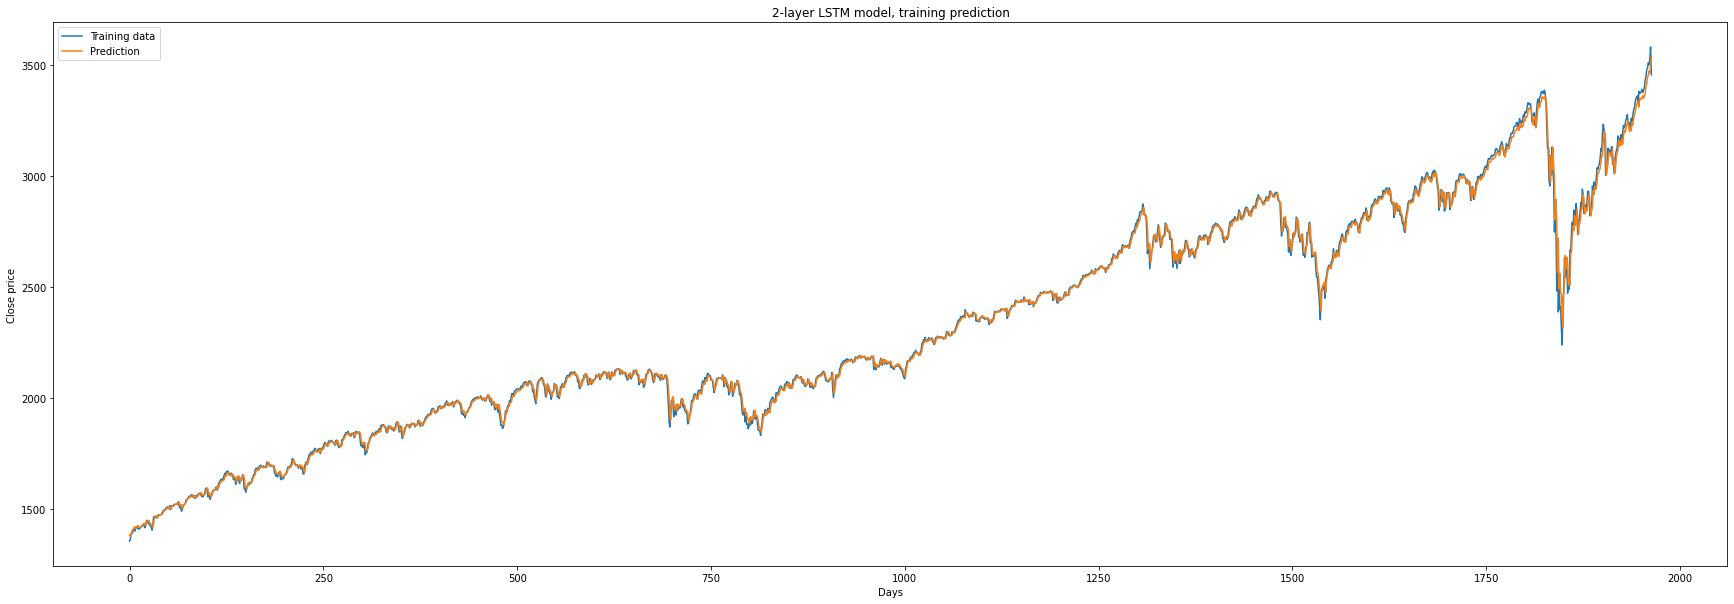

In [38]:
y_pred = lstm2_medium_final.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM2 = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM2.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "Training data")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM2, label = "Prediction" )
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("2-layer LSTM model, training prediction")
plt.legend()
plt.show()

In [42]:
dataset_val = validation_data.Close.values
dataset_val.shape

# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_val = np.reshape(dataset_val, (-1,1))
dataset_val.shape

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_val_scaled = scaler.fit_transform(dataset_val)
dataset_val_scaled.shape

(503, 1)

In [44]:
X_val = []
y_val = []

time_step = 50

for i in range(time_step, length_validation):
    X_val.append(dataset_val_scaled[i-time_step:i,0])
    y_val.append(dataset_val_scaled[i,0])
    
# convert list to array
X_val, y_val = np.array(X_val), np.array(y_val)

print("Shape of X_val before reshape :",X_val.shape)
print("Shape of y_val before reshape :",y_val.shape)


y_pred_val = lstm2_medium_final.predict(X_val)  # predictions
print("y_pred_val.shape", y_pred_val.shape)
y_predLSTM2_val = scaler.inverse_transform(y_pred_val) # scaling back from 0-1 to original
y_predLSTM2_val.shape

y_val_scaled = scaler.inverse_transform(y_val) # scaling back from 0-1 to original
y_val_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_val_scaled, label = "Validation data")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM2, label = "Prediction" )
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("2-layer LSTM model, validation prediction")
plt.legend()
plt.show()

Shape of X_val before reshape : (453, 50)
Shape of y_val before reshape : (453,)
(453, 1)


ValueError: Expected 2D array, got 1D array instead:
array=[0.25005127 0.23890774 0.21214517 0.22117294 0.20557314 0.2184287
 0.25550124 0.25180807 0.25738641 0.24666585 0.2728386  0.27704473
 0.27557642 0.29635054 0.29175964 0.29835734 0.27948764 0.27646132
 0.27348619 0.26324667 0.29346526 0.29766482 0.31132827 0.30294808
 0.29365748 0.28874615 0.29050938 0.29887673 0.31958666 0.31425205
 0.31745792 0.33286534 0.2973314  0.31413669 0.32778072 0.36346212
 0.37685617 0.36078206 0.36179501 0.36734126 0.35817244 0.34067479
 0.36033312 0.39427696 0.39505918 0.3876215  0.39652749 0.39284716
 0.32946709 0.35294037 0.306045   0.34427184 0.37790137 0.38037621
 0.40702984 0.4167052  0.43514536 0.43234977 0.43148413 0.43565175
 0.44748153 0.44604531 0.44523742 0.43410658 0.42945166 0.41008183
 0.41320442 0.44145441 0.37984414 0.36818107 0.42631639 0.40610017
 0.37367598 0.34081583 0.38792283 0.37472117 0.40940215 0.42438645
 0.45037323 0.45293792 0.46935187 0.46535737 0.47267326 0.43506192
 0.43354884 0.4511747  0.43189456 0.41818619 0.43125339 0.47294251
 0.47073049 0.46269015 0.47188448 0.50200695 0.53922054 0.5366751
 0.54052855 0.55156954 0.57184979 0.57133071 0.58005042 0.56919556
 0.59853551 0.60818536 0.5939446  0.57578668 0.60045903 0.57581235
 0.60478695 0.60956382 0.60898682 0.60671704 0.62485587 0.60542812
 0.61279536 0.5948425  0.59672094 0.61854025 0.63840379 0.61008321
 0.58678932 0.52968637 0.56139879 0.60073484 0.59396401 0.57122803
 0.56343783 0.59129037 0.58919998 0.61560988 0.60989067 0.61493052
 0.61806563 0.62013661 0.61880949 0.62270788 0.61291714 0.63666624
 0.63450541 0.63497971 0.63003629 0.64262276 0.64791871 0.65286213
 0.64737365 0.63269741 0.63151744 0.59599022 0.63339619 0.64727753
 0.64432807 0.66013325 0.6692443  0.67559812 0.67636108 0.68001589
 0.69440379 0.71517775 0.70953555 0.71889017 0.69496795 0.72621232
 0.73588127 0.72599442 0.72925789 0.72010834 0.6990332  0.65500386
 0.69640433 0.71924926 0.7248852  0.75329564 0.76003423 0.74667227
 0.74614662 0.75801459 0.74269687 0.73750361 0.76057929 0.7474418
 0.76439439 0.76915185 0.76647821 0.76929931 0.77292845 0.78473882
 0.78933598 0.7968441  0.77656385 0.74590931 0.74945486 0.77245383
 0.79672857 0.80102456 0.80741063 0.79061833 0.81586141 0.82831295
 0.82439546 0.82529931 0.83354502 0.83257043 0.8226961  0.81887473
 0.80554471 0.78329618 0.78980403 0.77333858 0.79747901 0.79302273
 0.76688865 0.71863376 0.71636398 0.74294075 0.77714085 0.78130848
 0.77337708 0.71536371 0.71974298 0.6864533  0.71819139 0.68191374
 0.71093342 0.72236528 0.74558215 0.74018352 0.7208522  0.7140942
 0.72252557 0.77026733 0.79149681 0.80117202 0.8224397  0.83305757
 0.84177102 0.83864216 0.85247874 0.85780693 0.8429895  0.87167544
 0.87742033 0.88273568 0.8936228  0.91280666 0.92530328 0.93650441
 0.93917836 0.92863093 0.90392008 0.90556152 0.92709218 0.92705993
 0.93866524 0.9308237  0.9409992  0.93678023 0.92714979 0.93212546
 0.93902433 0.87052145 0.90940856 0.85281216 0.81821446 0.85928808
 0.83449395 0.86862986 0.9295927  0.93886404 0.91721817 0.94579516
 0.91819277 0.8958284  0.94440387 0.91800023 0.8872048  0.85346617
 0.90553585 0.93588265 0.95462414 0.99655682 0.99345364 0.99775589
 0.98856783 0.98052122 1.         0.99806364 0.93846018 0.93555548
 0.92336035 0.919039   0.94646827 0.95498323 0.91181923 0.91426871
 0.85929434 0.83085823 0.79878046 0.74441533 0.75223119 0.7178132
 0.71363273 0.69861619 0.76615762 0.81982366 0.83969378 0.86716155
 0.79538862 0.81019322 0.79951148 0.82366444 0.86575116 0.81246957
 0.75768774 0.74680689 0.79130427 0.79383046 0.73307926 0.71295305
 0.68467066 0.6338514  0.67437369 0.7358941  0.72902716 0.68563242
 0.73710601 0.72232708 0.70012958 0.61820025 0.59871521 0.66743599
 0.65566413 0.62026497 0.60026023 0.65754288 0.71871704 0.75321863
 0.78620713 0.78496329 0.81729747 0.78179593 0.82277969 0.83746251
 0.85827497 0.89423204 0.87554189 0.82935172 0.83925767 0.8628402
 0.82595989 0.79776735 0.80998816 0.80233884 0.75376995 0.74410131
 0.77560836 0.74098498 0.74040799 0.78562356 0.78385407 0.74167124
 0.66352477 0.67913115 0.60160049 0.60721702 0.67360416 0.5738569
 0.58889223 0.60177988 0.68172777 0.583436   0.56834901 0.48365007
 0.48994002 0.44770585 0.44443596 0.50458433 0.49440257 0.54623509
 0.44033235 0.42565596 0.42602147 0.47243596 0.45174527 0.47562899
 0.5263523  0.59072621 0.57399778 0.55417275 0.60263896 0.55885976
 0.56712458 0.59229064 0.56349544 0.50069252 0.42570088 0.32873606
 0.31966352 0.3546139  0.27560851 0.28078283 0.33845636 0.33531451
 0.35829423 0.43267678 0.42522    0.37484937 0.3731054  0.35165802
 0.37727303 0.38115842 0.38993621 0.42682936 0.4247518  0.39593108
 0.37308615 0.36217336 0.35486389 0.40152852 0.38081232 0.44867403
 0.46355564 0.4885935  0.46466486 0.4680055  0.43864614 0.50440494
 0.53570692 0.57280529 0.5653291  0.54773534 0.58875761 0.58668663
 0.58235871 0.57906957 0.56779142 0.62406724 0.62216281 0.66889147
 0.67978516 0.68495305 0.66497399 0.67119349 0.63576208 0.57774245
 0.57180502 0.57952477 0.61693731 0.52623677 0.50889315 0.48039286
 0.46041395 0.46801192 0.44070428].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

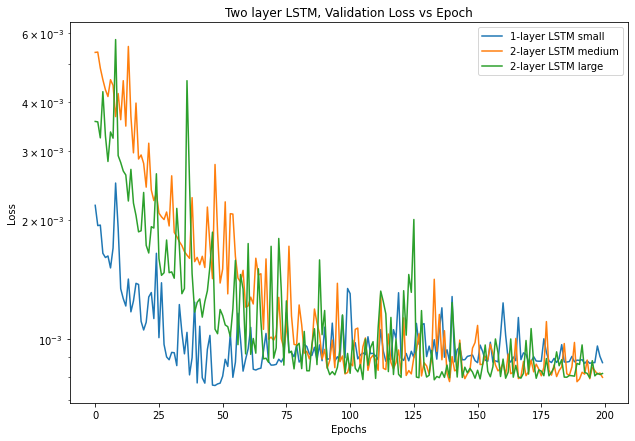

In [35]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(LSTMhistory1_large.history["val_loss"], label = '1-layer LSTM small')
plt.plot(LSTMhistory2_medium.history["val_loss"], label = '2-layer LSTM medium')
plt.plot(LSTMhistory2_large.history["val_loss"], label = '2-layer LSTM large')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two layer LSTM, Validation Loss vs Epoch")
plt.show()

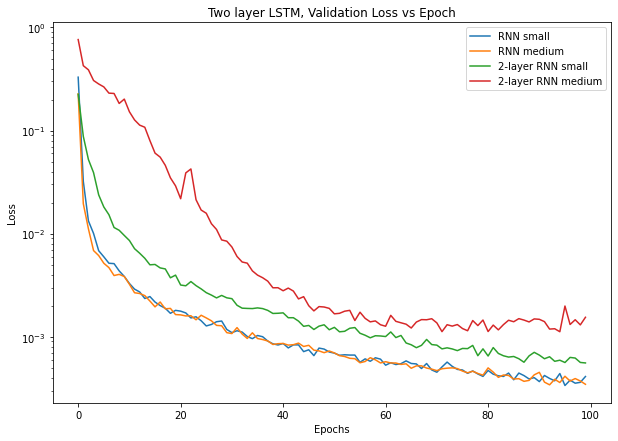

In [155]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory1.history["loss"], label = 'RNN small')
plt.plot(RNNhistory1_medium.history["loss"], label = 'RNN medium')
plt.plot(RNNhistory2.history["loss"], label = '2-layer RNN small')
plt.plot(RNNhistory2_medium.history["loss"], label = '2-layer RNN medium')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two layer LSTM, Validation Loss vs Epoch")
plt.show()

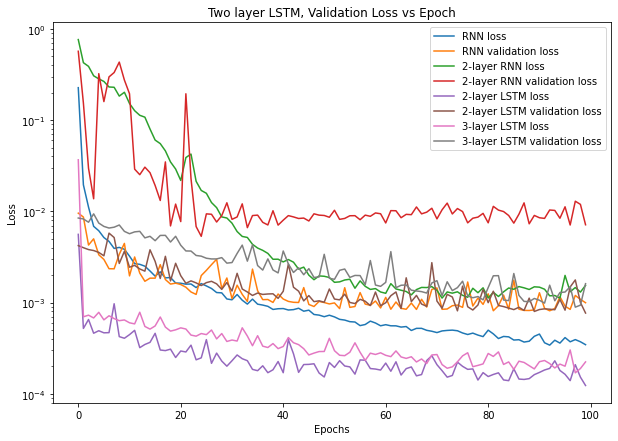

In [159]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory1_medium.history["loss"], label = 'RNN loss')
plt.plot(RNNhistory1_medium.history["val_loss"], label = 'RNN validation loss')
plt.plot(RNNhistory2_medium.history["loss"], label = '2-layer RNN loss')
plt.plot(RNNhistory2_medium.history["val_loss"], label = '2-layer RNN validation loss')
plt.plot(LSTMhistory2_medium.history["loss"], label = '2-layer LSTM loss')
plt.plot(LSTMhistory2_medium.history["val_loss"], label = '2-layer LSTM validation loss')
plt.plot(LSTMhistory3_medium.history["loss"], label = '3-layer LSTM loss')
plt.plot(LSTMhistory3_medium.history["val_loss"], label = '3-layer LSTM validation loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two layer LSTM, Validation Loss vs Epoch")
plt.show()

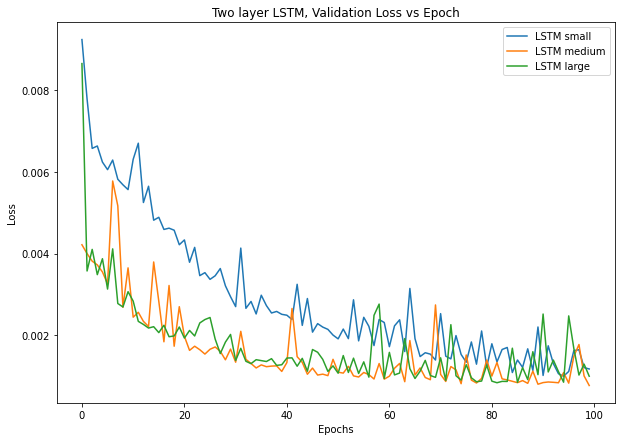

In [145]:
plt.figure(figsize =(10,7))
plt.plot(LSTMhistory2.history["val_loss"], label = 'LSTM small')
plt.plot(LSTMhistory2_medium.history["val_loss"], label = 'LSTM medium')
plt.plot(LSTMhistory2_large.history["val_loss"], label = 'LSTM large')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two layer LSTM, Validation Loss vs Epoch")
plt.show()

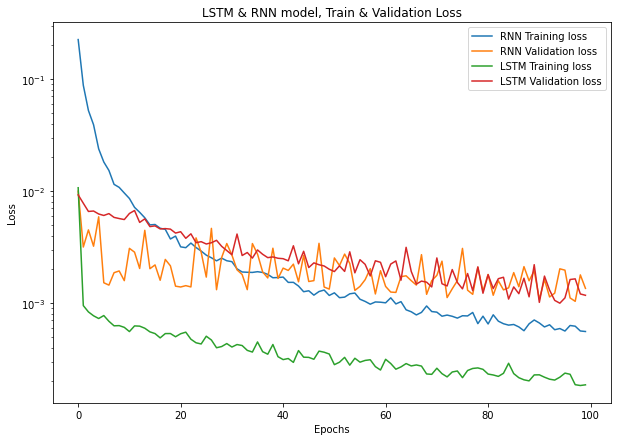

In [147]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory2.history["loss"], label = 'RNN Training loss')
plt.plot(RNNhistory2.history["val_loss"], label = 'RNN Validation loss')
plt.plot(LSTMhistory2.history["loss"], label = 'LSTM Training loss')
plt.plot(LSTMhistory2.history["val_loss"], label = 'LSTM Validation loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM & RNN model, Train & Validation Loss")
plt.show()

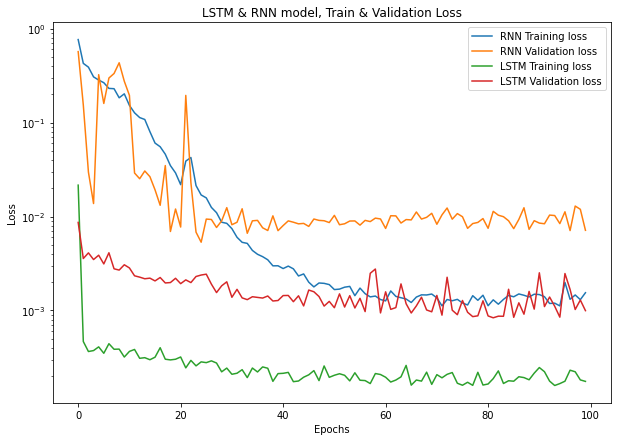

In [146]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory2_medium.history["loss"], label = 'RNN Training loss')
plt.plot(RNNhistory2_medium.history["val_loss"], label = 'RNN Validation loss')
plt.plot(LSTMhistory2_large.history["loss"], label = 'LSTM Training loss')
plt.plot(LSTMhistory2_large.history["val_loss"], label = 'LSTM Validation loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM & RNN model, Train & Validation Loss")
plt.show()

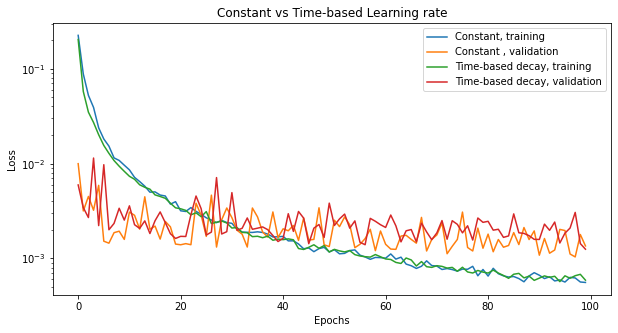

In [101]:
plt.figure(figsize =(10,5))
plt.yscale('log')
plt.plot(RNNhistory2.history["loss"], label = 'Constant, training')
plt.plot(RNNhistory2.history["val_loss"], label = 'Constant , validation')
plt.plot(RNNhistory2_LR_decay.history["loss"], label = 'Time-based decay, training')
plt.plot(RNNhistory2_LR_decay.history["val_loss"], label = 'Time-based decay, validation')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Constant vs Time-based Learning rate")
plt.show()

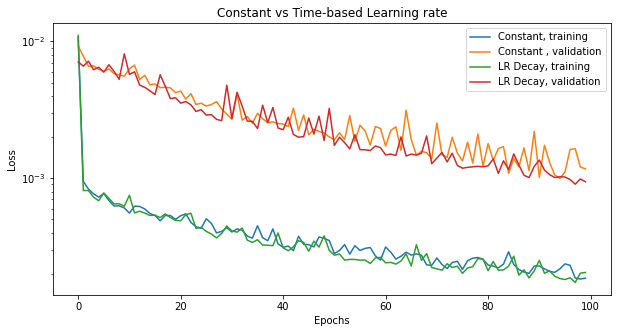

In [91]:
plt.figure(figsize =(10,5))
plt.yscale('log')
plt.plot(LSTMhistory2.history["loss"], label = 'Constant, training')
plt.plot(LSTMhistory2.history["val_loss"], label = 'Constant , validation')
plt.plot(LSTMhistory2_LR_decay.history["loss"], label = 'LR Decay, training')
plt.plot(LSTMhistory2_LR_decay.history["val_loss"], label = 'LR Decay, validation')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Constant vs Time-based Learning rate")
plt.show()

(1964, 1)


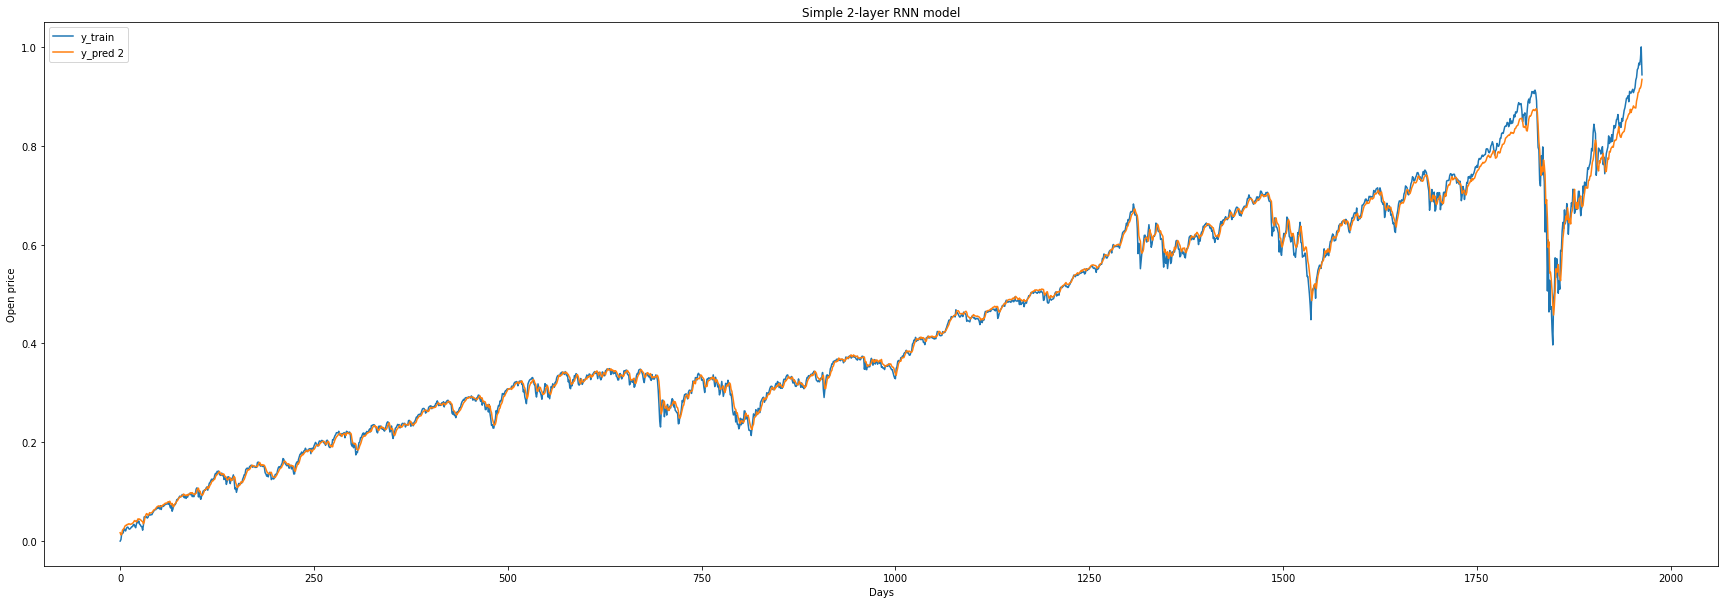

In [143]:
y_pred = RNN2.predict(X_train)  # predictions
print(y_pred.shape)
y_pred2 = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred2.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_pred2, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

(1964, 1)


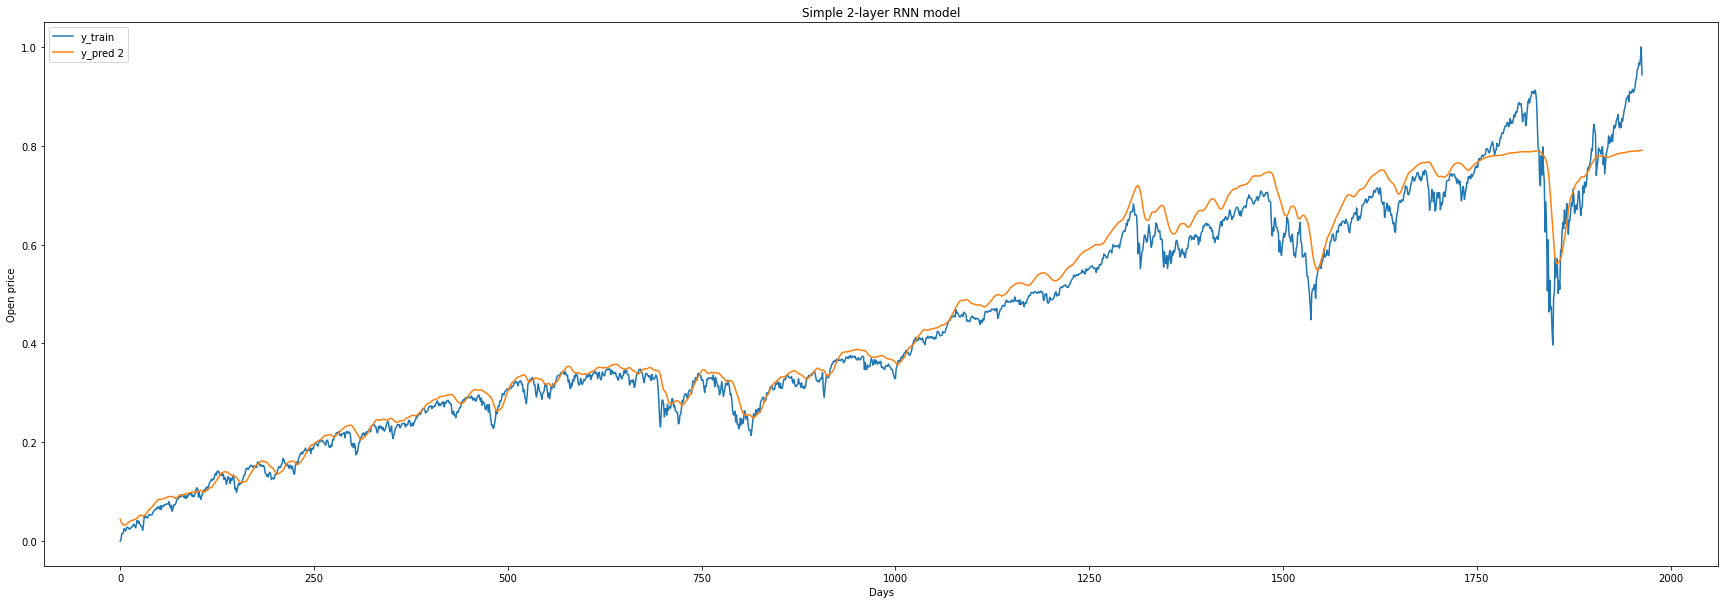

In [142]:
y_pred = RNN2_medium.predict(X_train)  # predictions
print(y_pred.shape)
y_pred2_medium = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred2_medium.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_pred2_medium, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

(1964, 1)


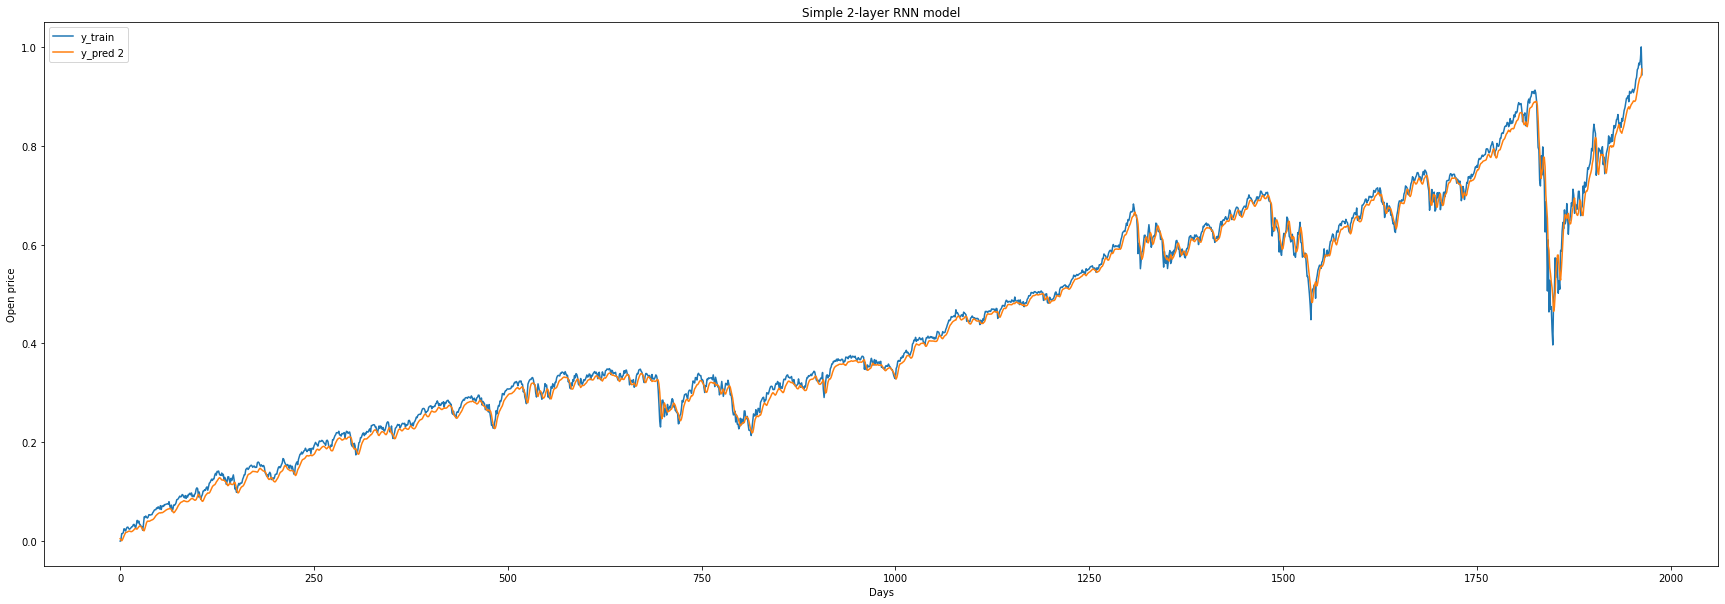

In [141]:
y_pred = lstm2.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM2 = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM2.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM2, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

(1964, 1)


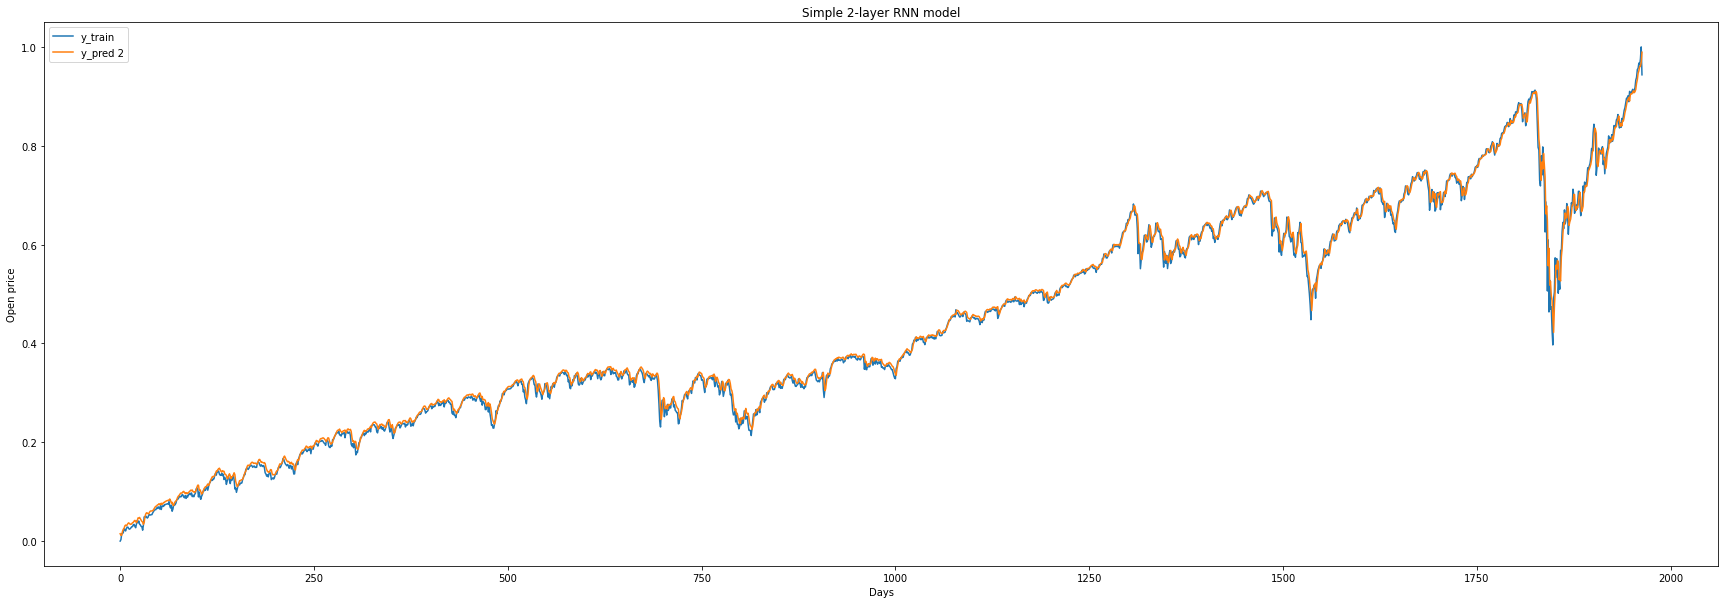

In [140]:
y_pred = lstm2_medium.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM2_medium = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM2_medium.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM2_medium, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

(1964, 1)


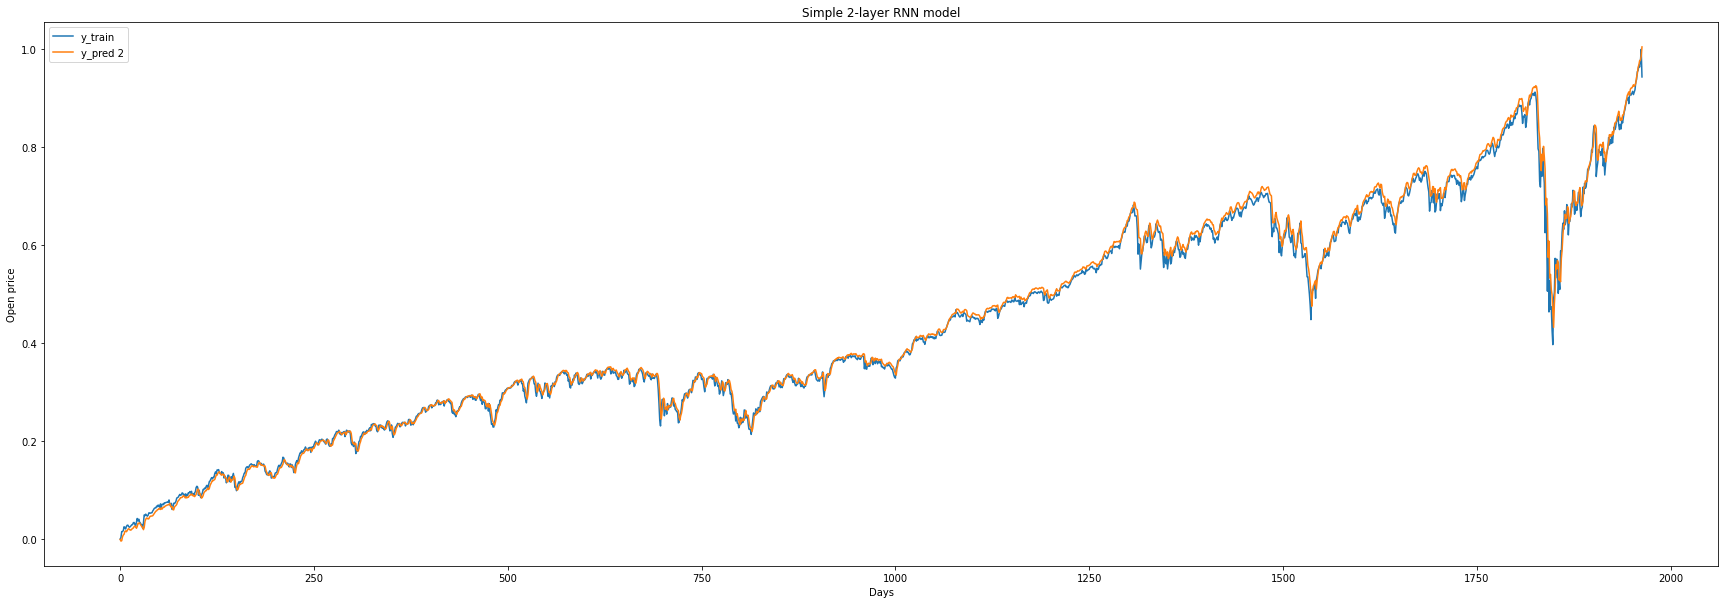

In [136]:
y_pred = lstm2_large.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM2_large = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM2_large.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM2_large, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

(1964, 1)


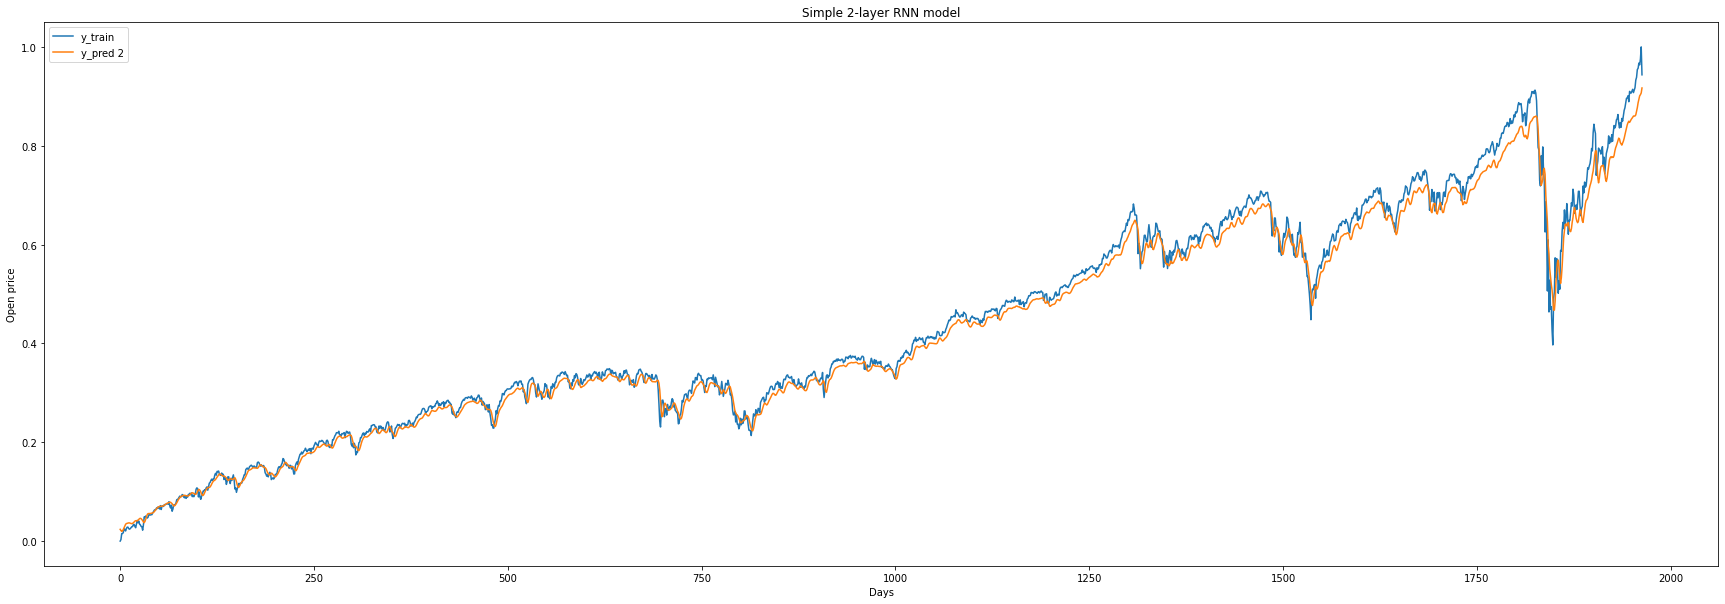

In [137]:
y_pred = lstm3.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM3 = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM3.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM3, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

In [170]:
# serialize model to JSON
model_json = lstm1_large.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm1_large.save_weights("model.h5")

In [199]:
# serialize model to JSON
model = RNN2_LR_decay
model_json = model.to_json()
with open("RNN2_LR_decay.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")